In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# import dataset from seaborn
import seaborn as sns
iris = sns.load_dataset("iris")

# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype = torch.long)
# labels[iris.species == "setosa"] = 0 # don't need
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally translate into dataloader objects
train_loader = DataLoader(train_data, shuffle = True, batch_size = 64, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0]) # this is not split up and batch size = 1

In [4]:
def createANewModel(L2lambda):
    # model Architecture
    ANNiris = nn.Sequential(
        nn.Linear(4, 64), # input layer
        nn.ReLU(), # activation unit
        nn.Linear(64, 64), # activation unit
        nn.ReLU(), # activation unit
        nn.Linear(64, 3) # output unit
    )

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr = .005, weight_decay = L2lambda)

    return ANNiris, lossfun, optimizer

In [5]:
# train the model

# training parameter
numepochs = 1000

def trainTheModel():
    trainAcc = []
    testAcc = []
    losses = []
    
    # train the model
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item())
            batchLoss.append(loss.item())
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # test accuracy
        ANNiris.eval() # switch training off
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        predlabels = torch.argmax(ANNiris(X), axis = 1)
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())

        ANNiris.train()
    
    # function output
    return trainAcc, testAcc, losses

In [6]:
# create a model
L2lambda = .01
ANNiris, lossfun, optimizer = createANewModel(L2lambda)

# train the model
trainAcc, testAcc, losses = trainTheModel()

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Admin\AppData\Local\Temp\ipykernel_8600\2191360961.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_title("Losses with L2 $\lambda$=" + str(L2lambda))
C:\Users\Admin\AppData\Local\Temp\ipykernel_8600\2191360961.py:13: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title("Accuracy with L2 $\lambda$=" + str(L2lambda))


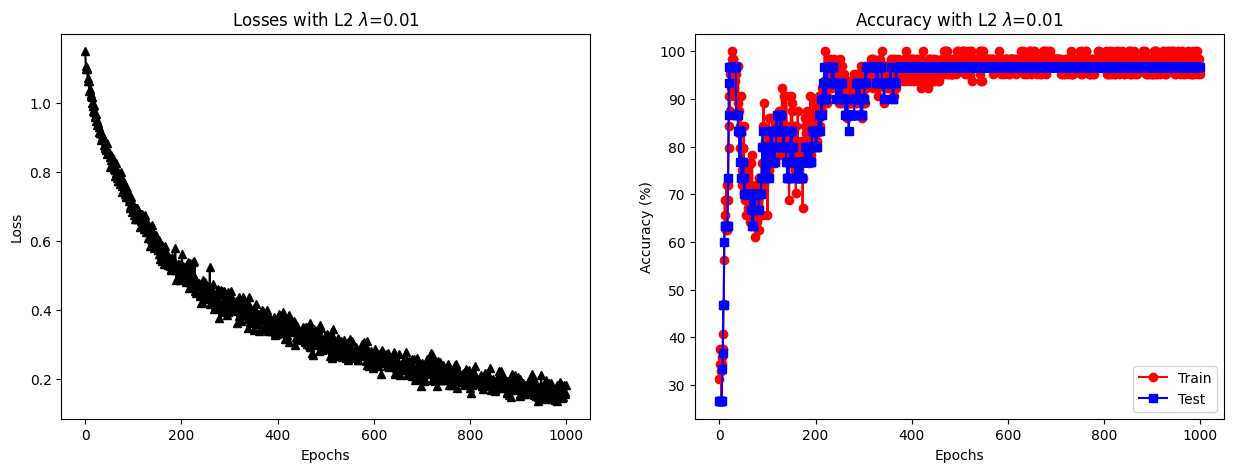

In [7]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(losses, "k^-")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_title("Losses with L2 $\lambda$=" + str(L2lambda))

ax[1].plot(trainAcc, "ro-")
ax[1].plot(testAcc, "bs-")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epochs")
ax[1].set_title("Accuracy with L2 $\lambda$=" + str(L2lambda))
ax[1].legend(["Train", "Test"])

plt.show()

In [8]:
# create a 1D smoothing filter
def smooth(x, k):
    return np.convolve(x, np.ones(k)/k, mode = "same")

In [9]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0, .1, 10)

# initialization output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(l2lambdas)))
accuracyResultsTest = np.zeros((numepochs, len(l2lambdas)))

# loop over batch sizes
for li in range(len(l2lambdas)):

    # create and train a model
    ANNiris, lossfun, optimizer = createANewModel(l2lambdas[li])
    trainAcc, testAcc, losses = trainTheModel()

    # store data
    accuracyResultsTrain[:, li] = smooth(trainAcc, 10)
    accuracyResultsTest[:, li] = smooth(testAcc, 10)

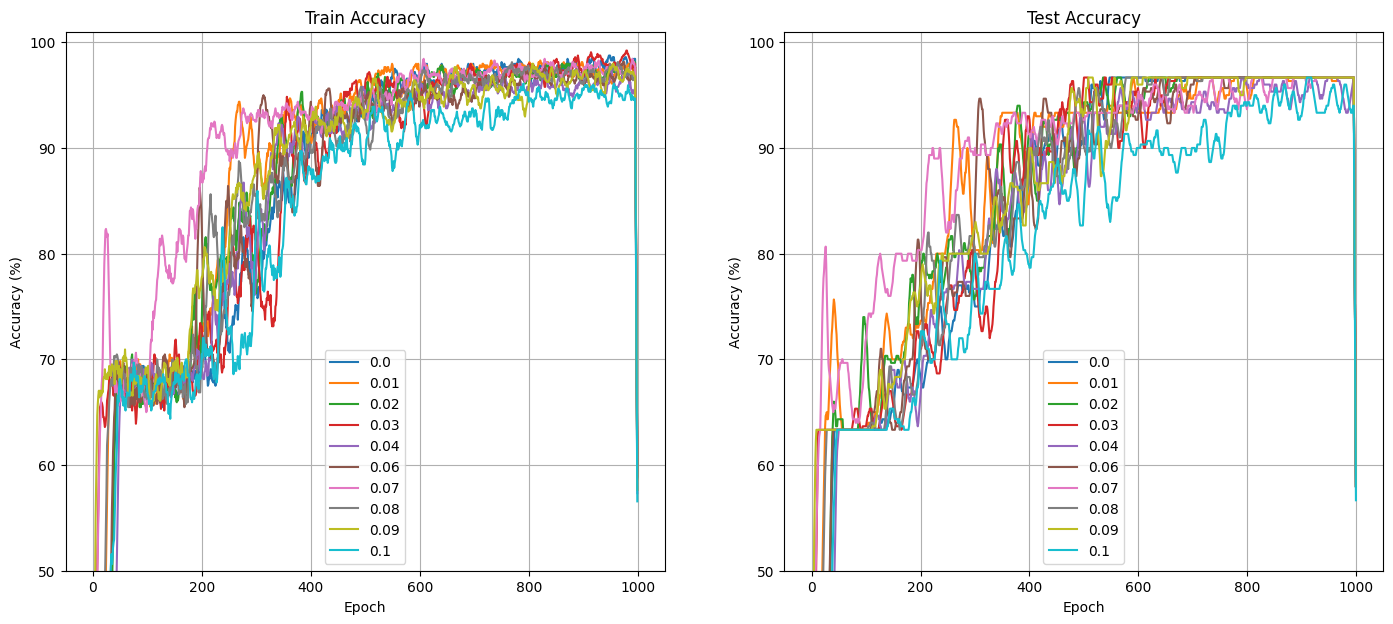

In [10]:
# plot some results
fig, ax = plt.subplots(1, 2, figsize = (17, 7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title("Train Accuracy")
ax[1].plot(accuracyResultsTest)
ax[1].set_title("Test Accuracy")

# make the legend easier to read
leglabels = [np.round(i, 2) for i in l2lambdas]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 101])
    ax[i].grid()

plt.show()

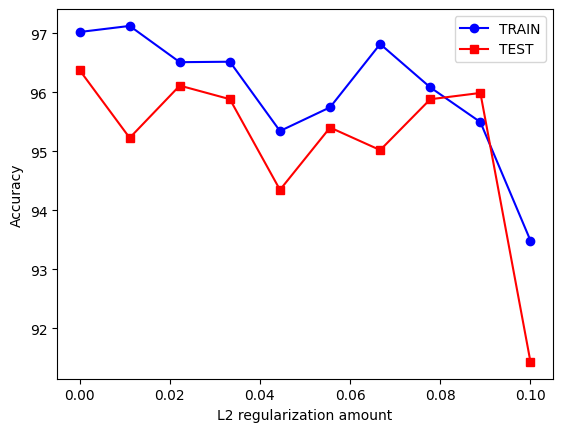

In [11]:
# show avg accuracy by L2 rate

# avg only some epochs
epoch_range = [500, 950]

plt.plot(l2lambdas, np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1], :], axis = 0), "bo-", label = "TRAIN")

plt.plot(l2lambdas, np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1], :], axis = 0), "rs-", label = "TEST")

plt.xlabel("L2 regularization amount")
plt.ylabel("Accuracy")
plt.legend()
plt.show()